In [129]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from scipy.optimize import NonlinearConstraint
import sklearn.metrics
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST

# Support Vector Machines

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

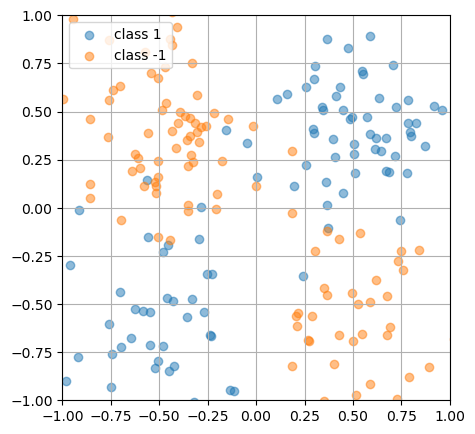

In [113]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
dataset = datasets['dataset_3']

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax)


## III- Kernel SVC 
### 1- Implementing the Gaussian and linear kernels

Implement the method 'kernel' of the classes RBF and Linear below. The RBF kernel which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/\sigma^2)$. (The fastest solution does not use any for loop!)

In [114]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        p = X.shape[0]
        n = Y.shape[0]
        dim = X.shape[1:]
        X = np.reshape(X, (p,1) + dim)
        Y = np.reshape(Y, (1,n) + dim)
        D = np.sum((X - Y)**2, axis = -1)
        return  np.exp(-D/(self.sigma**2)) ## Matrix of shape NxM

In [115]:
class Linear:
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return np.dot(X,Y.T)## Matrix of shape NxM


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

Recall the optimization problem we look to solve is:

\begin{aligned}
\min_{f\in \mathcal{H}, b,\xi \in \mathcal{R}^n} C\sum_i \xi_i + \frac{1}{2}||f||_{\mathcal{H}}^2\\
(f(x_i) + b)y_i + \xi_i \geq 1 \, i \in \{1, \cdots, N\}\\
\xi_i>0 \, i \in \{1, \cdots, N\}\\
\end{aligned}

With kernel's trick and lagrangian duality, you can reformulate it as:
\begin{aligned}
\max_{\beta \in \mathbb{R}^N} \beta^\top \text{diag}(y) - \frac{1}{2}\beta^\top K \beta\\
\sum_i \beta_i=0\\
C\mathbf{1} - \text{diag}(y)\beta \geq 0 \\
\beta_i y_i \geq 0\\
\end{aligned}


In [134]:
class KernelSVC:

    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C #Hyperparameter
        self.kernel = kernel
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y) #Number of points
        rbf = RBF() #definition of an object RBF
        kernel = rbf.kernel(X,X) #Calculations of the RBF kernel associated to X

        # Lagrange dual problem
        def loss(alpha):
            return 1/2*alpha.T @ kernel @ alpha - np.dot(alpha,y)#'''--------------dual loss ------------------ '''

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return kernel @ alpha - y#'''----------------partial derivative of the dual loss wrt alpha -----------------'''

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        Diag = np.concatenate((-np.diag(y), np.diag(y)))
        f1 = np.zeros(N)
        f2 = np.ones(N)*self.C
        f = np.concatenate((f1,f2), axis=0)
        fun_eq = lambda alpha: np.sum(alpha) #'''----------------function defining the equality constraint------------------'''
        jac_eq = lambda alpha: np.ones(alpha.shape)  #'''----------------jacobian wrt alpha of the equality constraint------------------'''
        fun_ineq = lambda alpha: f - Diag @ alpha  #'''---------------function defining the inequality constraint-------------------'''
        jac_ineq = lambda alpha: -Diag  # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''

        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes

        self.margin_points = X[self.alpha == self.C] #'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------'''

        e = X[np.where((self.alpha > 1e-10) & (self.alpha < self.C))]
        ind = y[np.where((self.alpha > 1e-10) & (self.alpha < self.C))]
        self.b = ind[0] - (self.alpha @ rbf.kernel(X, e))[0]
        self.norm_f = self.alpha @ kernel @ self.alpha # '''------------------------RKHS norm of the function f ------------------------------'''

        self.support = X

    ### Implementation of the separating function $f$
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return  self.alpha @ self.kernel(self.support,x)

    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d + self.b> 0) - 1
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        f1_score = sklearn.metrics.f1_score(y_test, y_pred)
        precision = np.count_nonzero(y_test == y_pred)/len(y_test)
        return precision, f1_score

### 3- Fitting the classifier

Run the code block below to fit the classifier and report its output.

### Dataset 1
#### Linear classifier

Number of support vectors = 100
The f1_score is 0.99, and the classifier's precision is 98.88


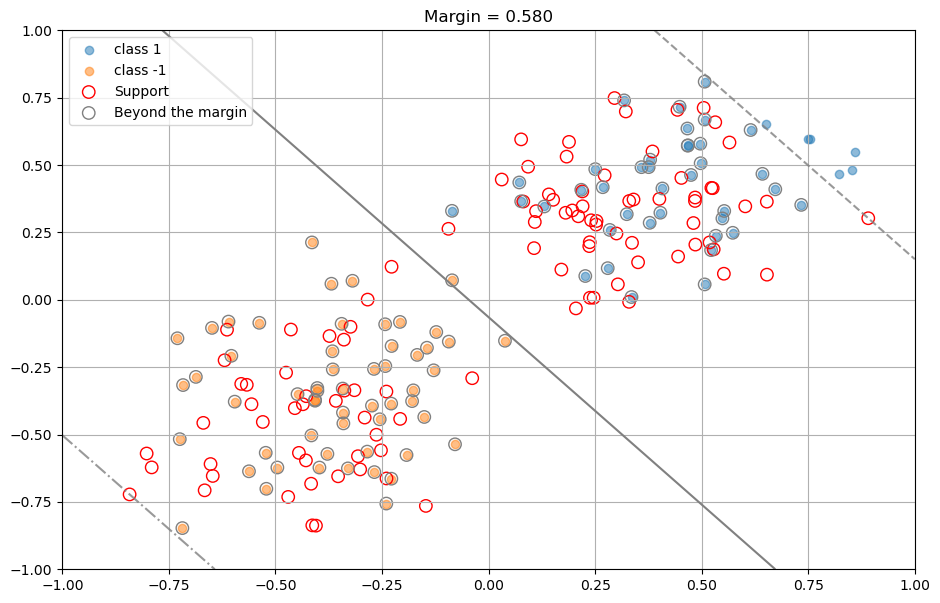

In [ ]:
C= 1e0 #provide a reasonable value
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']
test_dataset = datasets['dataset_1']['test']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(test_dataset['x'], test_dataset['y'], model, label='Training')
f1_score, precision= model.evaluate(test_dataset['x'], test_dataset['y'])
print(f"The f1_score is {f1_score}, and the classifier's precision is {100*precision:.2f}%")

#### Gaussian classifier

Number of support vectors = 100
The f1_score is 0.98, and the classifier's precision is 97.78%


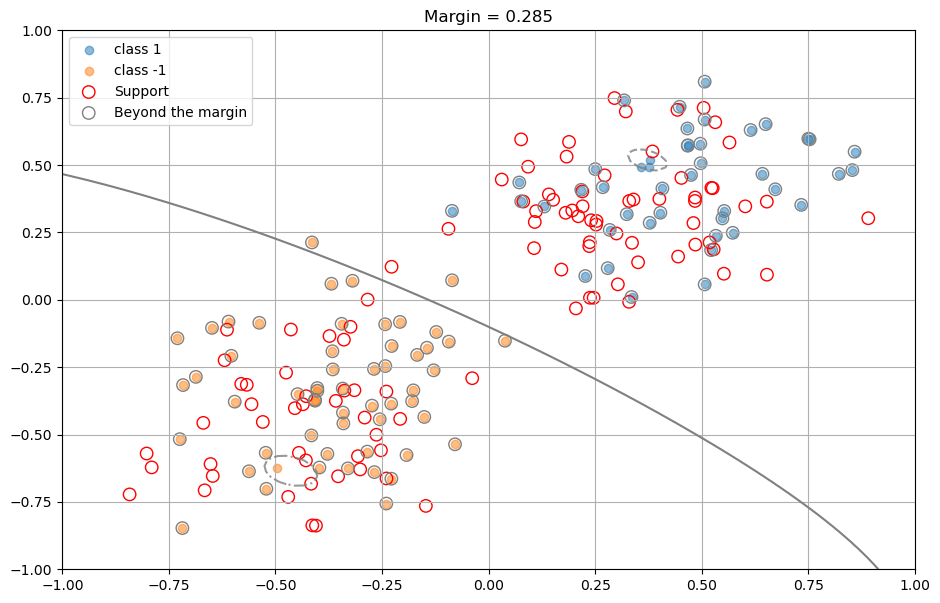

In [140]:
sigma = 1 #: provide a reasonalbe value
C= 1e1 #: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']
test_dataset = datasets['dataset_1']['test']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(test_dataset['x'], test_dataset['y'], model, label='Training')
f1_score, precision= model.evaluate(test_dataset['x'], test_dataset['y'])
print(f"The f1_score is {f1_score}, and the classifier's precision is {100*precision:.2f}%")

### Dataset 2
#### Linear SVM

Number of support vectors = 100
The f1_score is 0.85, and the classifier's precision is 84.21%


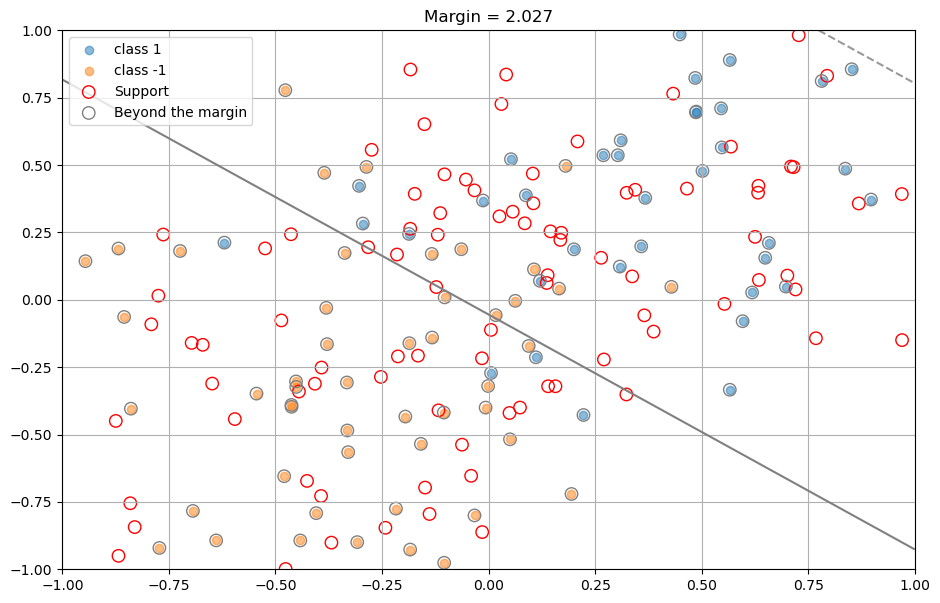

In [141]:
C= 0.1
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_2']['train']
test_dataset = datasets['dataset_2']['test']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(test_dataset['x'], test_dataset['y'], model, label='Training')
f1_score, precision= model.evaluate(test_dataset['x'], test_dataset['y'])
print(f"The f1_score is {f1_score}, and the classifier's precision is {100*precision:.2f}%")

#### Gaussian SVM

Number of support vectors = 100
The f1_score is 0.85, and the classifier's precision is 84.85%


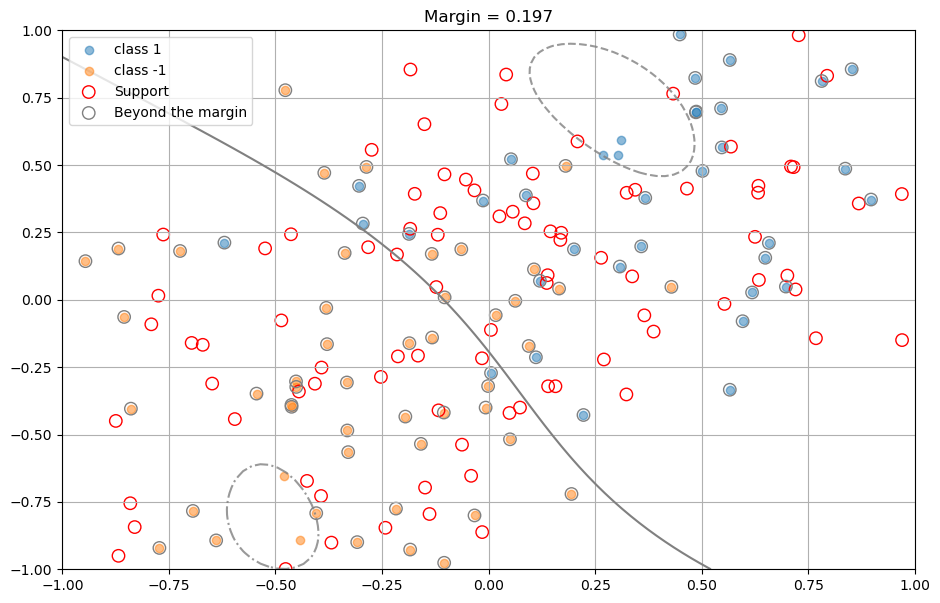

In [142]:
sigma = 1
C= 1e1
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_2']['train']
test_dataset = datasets['dataset_2']['test']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(test_dataset['x'], test_dataset['y'], model, label='Training')
f1_score, precision= model.evaluate(test_dataset['x'], test_dataset['y'])
print(f"The f1_score is {f1_score}, and the classifier's precision is {100*precision:.2f}%")

### Dataset 3
#### Linear SVM

Number of support vectors = 200
The f1_score is 0.565, and the classifier's precision is 60.99%


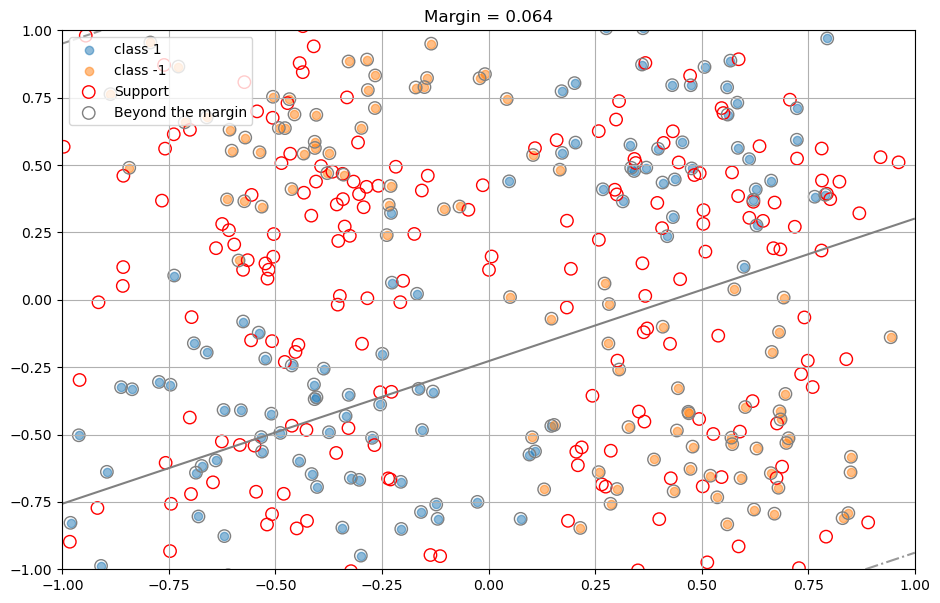

In [143]:
C= 1e1
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_3']['train']
test_dataset = datasets['dataset_3']['test']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(test_dataset['x'], test_dataset['y'], model, label='Training')
f1_score, precision= model.evaluate(test_dataset['x'], test_dataset['y'])
print(f"The f1_score is {f1_score}, and the classifier's precision is {100*precision:.2f}%")

#### Gaussian SVM

Number of support vectors = 200
The f1_score is 0.9, and the classifier's precision is 90.29%


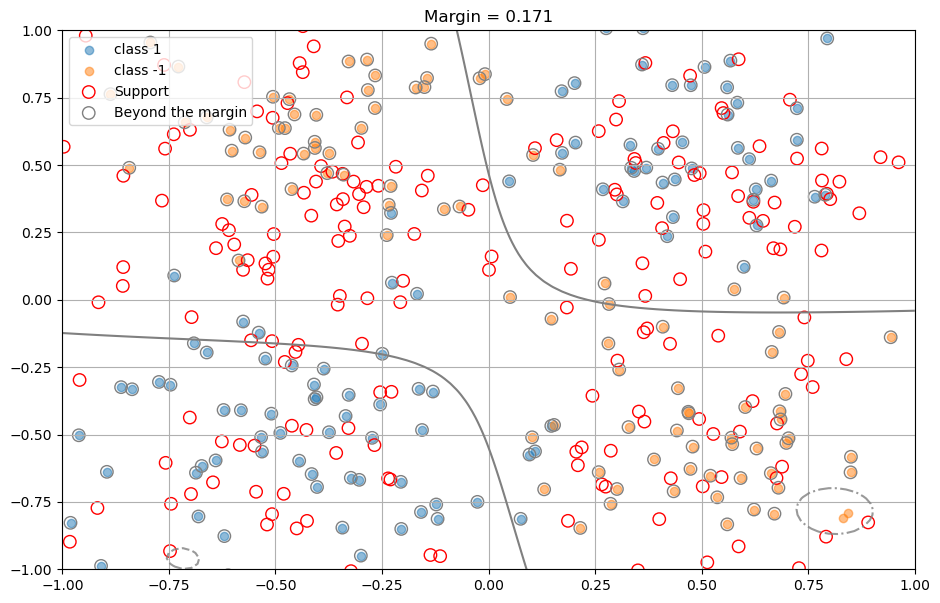

In [145]:
sigma = 1#: provide a reasonable value
C= 1 #: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
test_dataset = datasets['dataset_3']['test']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(test_dataset['x'], test_dataset['y'], model, label='Training')
f1_score, precision= model.evaluate(test_dataset['x'], test_dataset['y'])
print(f"The f1_score is {f1_score}, and the classifier's precision is {100*precision:.2f}%")

# Kernel Regression

## Loading the data

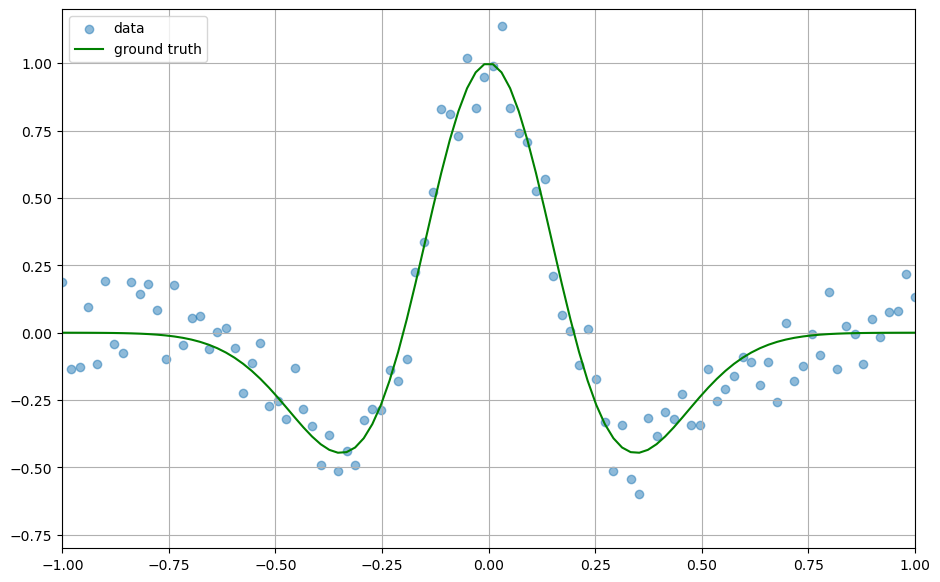

In [37]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])

## Kernel Ridge Regression
### 1- Implementing the regressor
Implement the method 'fit' of the classes KernelRR and MultivariateKernelRR below to perform Kernel Ridge Regression. 

In [75]:
class KernelRR:

    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda
        self.kernel = kernel
        self.alpha = None
        self.b = None
        self.support = None
        self.type='ridge'

    def fit(self, X, y):

        N = X.shape[0] #Number of samples
        X = X.reshape(N,-1)

        self.support = X

        K = self.kernel(X,X)
        K_ridge = K + np.eye(N)*self.lmbda*N
        inv_den = np.linalg.solve(K_ridge, np.ones(N))
        inv_num = np.linalg.solve(K_ridge,y)
        self.b = (np.sum(K @ inv_num) - np.sum(y))/(np.sum(K @ inv_den) - N)
        self.alpha = np.linalg.solve(K_ridge,y - self.b)

    ### Implementation of the separting function $f$
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        N = x.shape[0]
        x = x.reshape(N,-1)
        return self.kernel(x, self.support) @ self.alpha

    def predict(self, X):
        return self.regression_function(X) + self.b

class MultivariateKernelRR:
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda
        self.kernel = kernel
        self.support = None
        self.alpha = None
        self.b = None
        self.type='ridge'

    def fit(self, X, y):
        """
        X is an array of size N x d.
        y is an array of size N x q (if it is q x N, reshape it so it becomes N x q).

        Optimize the KRR objective to find the right coefficients.
        """

        N = X.shape[0] #Number of samples
        dim = X.shape[1:]

        y = y.reshape(N,-1)
        X = X.reshape(N,-1)
        K = self.kernel(X,X)

        self.support = X

        K_ridge = K + np.eye(N)*self.lmbda/2*N
        inv_den = np.linalg.solve(K_ridge, np.ones(N))
        inv_num = np.linalg.solve(K_ridge, y)
        self.b = (np.sum(K @ inv_num, axis = 0) - np.sum(y, axis = 0))/(np.sum(K @ inv_den) - N)
        self.alpha = np.linalg.solve(K_ridge, y - self.b)

    ## Implementation of the separating function $f$
    def regression_function(self,x):
        """
        Input : matrix x of shape N data points times d dimension
        Output: vector of size N x q
        """
        N = x.shape[0]
        x = x.reshape(N,-1)
        return self.kernel(x,self.support) @ self.alpha

    def predict(self, X):
        return self.regression_function(X) + np.expand_dims(self.b, axis = 0)

In [97]:
class WKernelRR:
    def __init__(self,kernel,lmbda, weight: list[float] = None):
        self.lmbda = lmbda
        self.kernel = kernel
        self.alpha = None 
        self.b = None
        self.support = None
        self.type='ridge'
        self.weight = weight

    def fit(self, X, y):

        N = X.shape[0] #Number of samples
        X = X.reshape(N,-1)

        if isinstance(self.weight, type(None)):
            self.weight = np.ones(N)
        elif isinstance(self.weight, list):
            assert all(self.weight > 0), "The weights of the matrix should all be positive." 
            assert len(self.weight) == N, "The number of weight should equal the number of samples"
        
        self.support = X

        K = self.kernel(X,X)
        K_ridge = K + self.lmbda*N/(2*self.weight)*np.eye(N)
        inv_den = np.linalg.solve(K_ridge, np.ones(N))
        inv_num = np.linalg.solve(K_ridge,y)
        self.b = (np.sum(np.diag(self.weight) @ K @ inv_num) - np.sum(self.weight*y))/(np.sum(np.diag(self.weight) @ K @ inv_den) - np.sum(self.weight))
        self.alpha = np.linalg.solve(K_ridge,y - self.b)

    ### Implementation of the separting function $f$
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        N = x.shape[0]
        x = x.reshape(N,-1)
        return self.kernel(x, self.support) @ self.alpha

    def predict(self, X):
        return self.regression_function(X) + self.b

        self.support = X

        K = self.kernel(X,X)
        K_ridge = K + self.lmbda*N/(2*self.weight)
        inv_den = np.linalg.solve(K_ridge, np.ones(N))
        inv_num = np.linalg.solve(K_ridge,y)
        self.b = (np.diag(self.weight) @ np.sum(K @ inv_num) - np.sum(self.weight*y))/(np.sum(np.diag(self.weight) @ K @ inv_den) - np.sum(self.weight))
        self.alpha = np.linalg.solve(K_ridge,y - self.b)

    ### Implementation of the separting function $f$
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        N = x.shape[0]
        x = x.reshape(N,-1)
        return self.kernel(x, self.support) @ self.alpha

    def predict(self, X):
        return self.regression_function(X) + self.b

### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

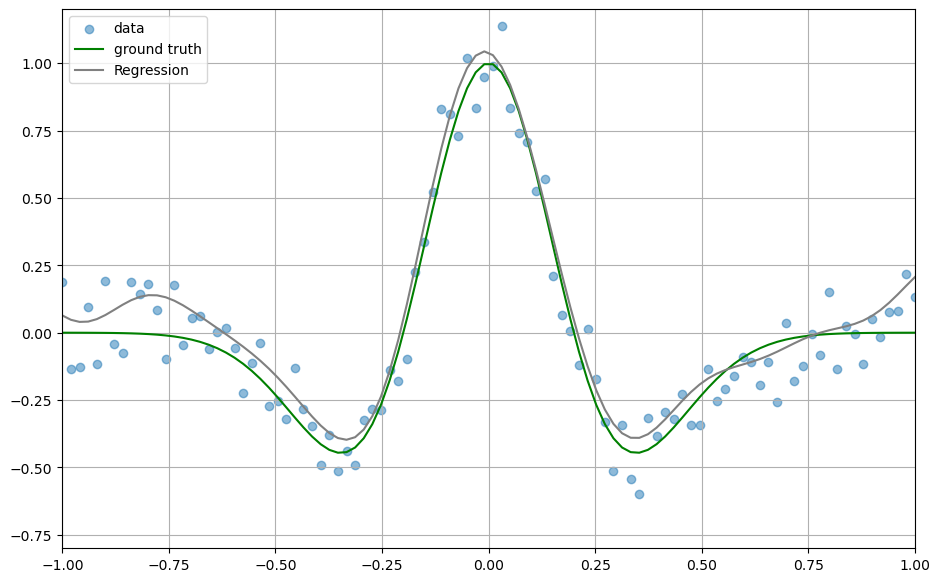

In [111]:
sigma = 0.2
N = train_set['x'].shape[0]
lmbda= 1e-3
kernel = RBF(sigma).kernel
model = WKernelRR(kernel, lmbda=lmbda)
train_set_2D = train_set['y']
model.fit(train_set['x'].reshape(-1,1), train_set_2D)
train_set_x = train_set['x'].reshape(train_set['x'].shape[0], 1)
train_set_y = train_set['y'].reshape(train_set['y'].shape[0], 1)
plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')

### Multivariate Kernel Ridge Regression

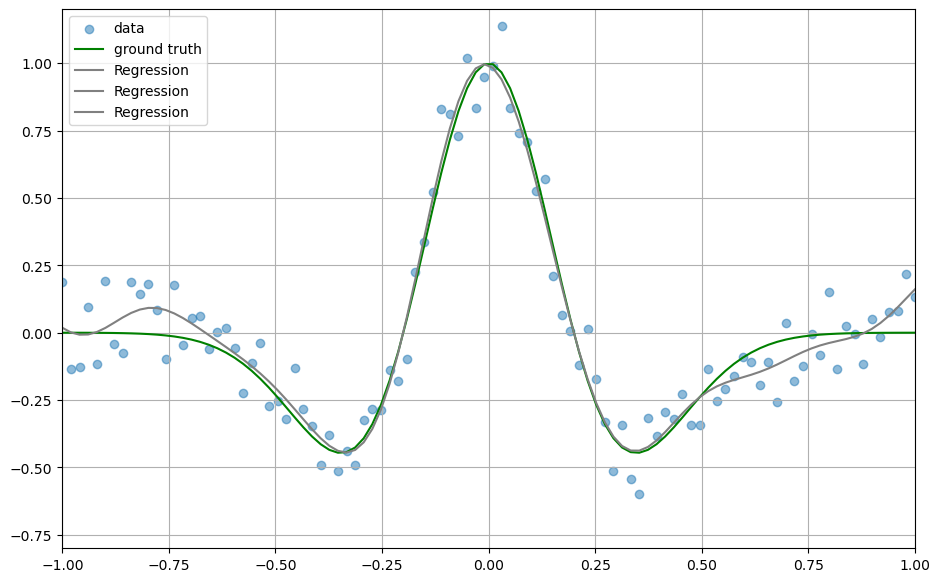

In [28]:
sigma = 0.2
lmbda= 1e-3
kernel = RBF(sigma).kernel
model = MultivariateKernelRR(kernel, lmbda=lmbda)
train_set_2D = np.repeat(train_set['y'][:,None], 3, axis = 1)
train_set_2D[:,1] += 2
train_set_2D[:,2] += 4
model.fit(train_set['x'].reshape(-1,1), train_set_2D)
train_set_x = train_set['x'].reshape(train_set['x'].shape[0], 1)
train_set_y = train_set['y'].reshape(train_set['y'].shape[0], 1)
plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')

# Kernel PCA

### 1- Implementing kernel PCA
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 

We note $\tilde{\Phi}(x_i)$ the centered feature vector, defined as: $\tilde{\Phi}(x_i) = \Phi(x_i) - \frac{1}{n}\sum_j \Phi(x_j)$
Assume we have found k-th eigenvector of the Gram matrix. We can note it $f_k$, by the representer theorem, it can be written as $f_k=\sum \alpha^k_i \tilde{K}_{x_i} = \sum \alpha^k_i \tilde{\Phi}(x_i)$, and so projecting a function $f$ along the k-th main component yields naturally:
$\langle f_k, f \rangle_{\mathcal{H}}$, because the set of eigenvector is orthogonal, that is $\langle f_i, f_j\rangle=\delta_{i,j}$. If one wants the projection of a point $x \in \mathcal{X}$, then it is simply $\langle \Phi(x), f_k\rangle=\sum_{i=1}^n \langle \Phi(x), \tilde{\Phi}(x_i)\rangle\alpha_i^k = \sum_{i=1}^n \langle \Phi(x), \Phi(x_i)\rangle\alpha_i^k - \frac{1}{n}\sum_i\sum_j \langle \Phi(x), \Phi(x_j) \rangle \alpha_i^k$.

Note the clean trick to center a matrix by multiplication:
$\tilde{K}=CKC$, avec $C=\mathbf{1} - \frac{1}{n}O$, where $O$ is the $n \times n$ square matrix whose entries are only ones.

In [8]:
class kernelPCA:

    def __init__(self,kernel, r=2):
        self.kernel = kernel
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corresp
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.support = None # Data points where the features are evaluated
        self.r = r # Number of principal components
        self.dim = None #Dimension of data

    def compute_PCA(self, X):
        """
        Compute the r-first eigenvalues/eigenvectors of K(X,X). 
        """
        N = X.shape[0]
        self.dim = X.shape[1:]

        X = X.reshape(N,-1)

        self.support=X #Support vectors

        kern = self.kernel(X,X) #Kernel

        C = np.eye(kern.shape[0])-np.ones(kern.shape)/kern.shape[0] # centering matrix

        Ku = C@kern@C #Centering the kernel

        self.lmbda, self.alpha = np.linalg.eig(Ku) #Compute the eigenvalues/eigenvectors

        self.lmbda = self.lmbda[1: 1 + self.r].real #

        self.alpha = self.alpha[:,1: 1 + self.r].real #already normalized to unity
    
    def center_matrix(self, K):

        M=K.shape[0]
        N=K.shape[1]
        C1=np.eye(M)-np.ones((M,M))/M


    def transform(self,x):
        """
        Input : matrix x of shape N data points times d dimension
        Output: vector of size N x r

        Projects the vector x onto the first eigenvalues.
        """

        M = x.shape[0]

        N = self.support.shape[0]

        Z = np.empty((M, self.r))

        x = x.reshape(M,-1)

        K = self.kernel(self.support,x)

        for i in range(self.r):
            Z[:,i] = self.alpha.T[i] @ K - 1/N*np.sum(self.alpha[:,i])*np.sum(K,axis = 0)
        return Z

### 2- Performing kernel PCA

Run the code block below apply a kernel PCA to a dataset consisting of three concentric rings and report the output. What can you conclude about this dataset?

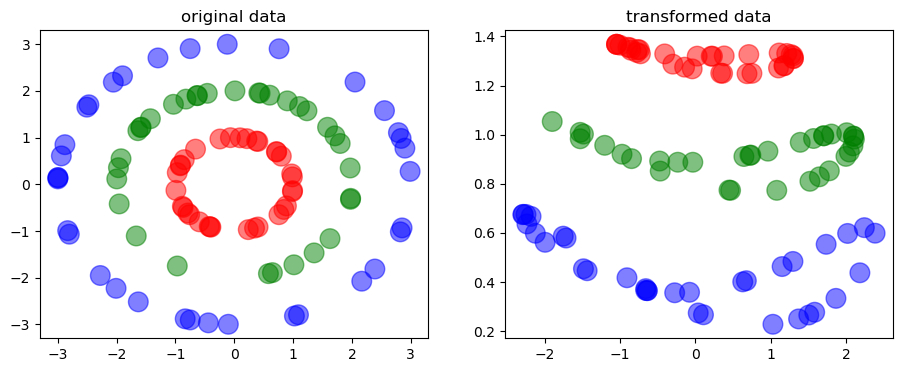

In [10]:
file = open('datasets/pca_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
test_set = datasets['dataset_1']['test']
sigma = 4
kernel = RBF(sigma).kernel
pca = kernelPCA(kernel, r=2)
pca.compute_PCA(train_set['x'])
pca_components = pca.transform(train_set['x'])

fig, ax = plt.subplots(1,2, figsize=(11, 4))
scatter_label_points(train_set['x'], train_set['y'], ax[0], title='original data')
scatter_label_points(pca_components,train_set['y'], ax[1], title= 'transformed data')

# Denoising 
### 1- Implementing a denoiser based on Kernel PCA and Kernel Ridge Regression
Implement the methods 'fit' and 'denoise' of the classes Denoiser below. 

The right strategy is to first perform a PCA on the data, and then a KRR on the reduced data.

In [9]:
class Denoiser:
    def __init__(self, kernel_encoder, kernel_decoder, dim_pca, lmbda):
        self.pca = kernelPCA(kernel_encoder, r = dim_pca)
        self.ridge_reg = MultivariateKernelRR(kernel_decoder, lmbda= lmbda)

    def fit(self,train):
    #Encoder
        self.pca.compute_PCA(train) #Compute the eigenvalues
        X = self.pca.transform(train) #Project along the eigenvalues axis

    #Decoder
        self.ridge_reg.fit(X,train)

    def denoise(self,test):
        proj_test = self.pca.transform(test) #Encoder
        return self.ridge_reg.predict(proj_test) #Decoder


### 2- Denoising MNIST dataset

Run the code block below to perform denoising of a subset of MNIST digits dataset and report the output. To what extent the denoising is successful? How can it be improved?

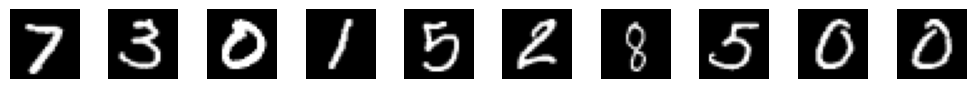

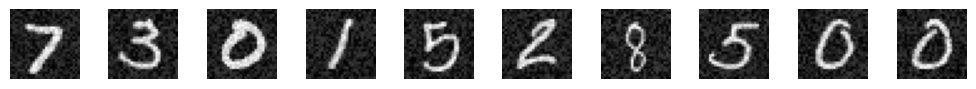

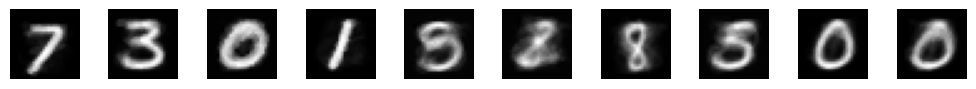

In [10]:
datasets = loadMNIST('datasets/SubsetMNIST')
clean_data = datasets['cleanMNIST']
data = datasets['noisyMNIST']
data = clean_data["test"] + np.random.rand(2000,28,28)*.3

dim_pca = 80
lmbda = 1e-7
sigma_encoder = 8.
sigma_decoder = 1
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit(clean_data['train'].astype("float32"))
pred = denoiser.denoise(data.astype("float32"))
pred = pred.reshape(data.shape)

plot_multiple_images(clean_data['test'])
plot_multiple_images(data)
plot_multiple_images(pred)

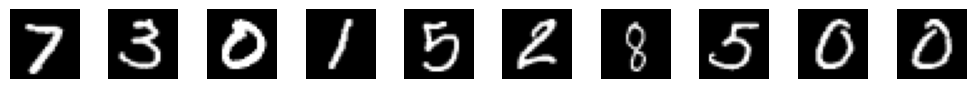

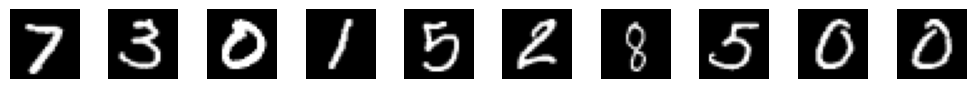

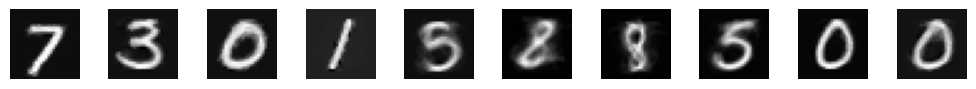

In [ ]:
datasets = loadMNIST('datasets/SubsetMNIST')
clean_data = datasets['cleanMNIST']
data = datasets['noisyMNIST']
data = clean_data["test"] + np.random.rand(2000,28,28)*0

dim_pca = 80
lmbda = 1e-7
sigma_encoder = 8.
sigma_decoder = 1
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit(clean_data['train'].astype("float32"))
pred = denoiser.denoise(data.astype("float32"))
pred = pred.reshape(data.shape)

plot_multiple_images(clean_data['test'])
plot_multiple_images(data)
plot_multiple_images(pred)

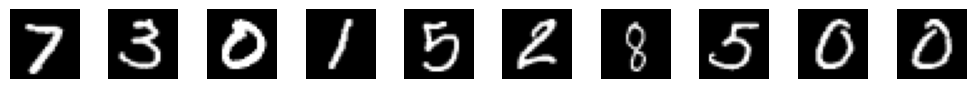

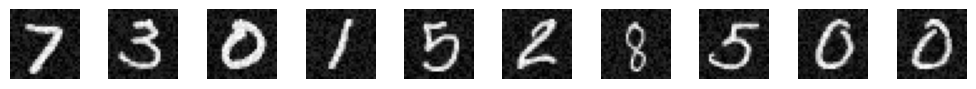

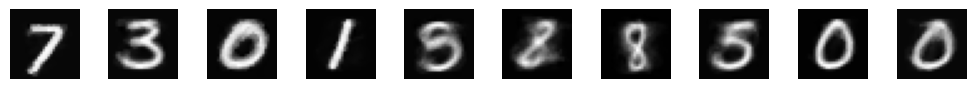

In [37]:
datasets = loadMNIST('datasets/SubsetMNIST')
clean_data = datasets['cleanMNIST']
data = datasets['noisyMNIST']
data = clean_data["test"] + np.random.rand(2000,28,28)*0.2

dim_pca = 80
lmbda = 1e-7
sigma_encoder = 8.
sigma_decoder = 1
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit(clean_data['train'].astype("float32"))
pred = denoiser.denoise(data.astype("float32"))
pred = pred.reshape(data.shape)

plot_multiple_images(clean_data['test'])
plot_multiple_images(data)
plot_multiple_images(pred)

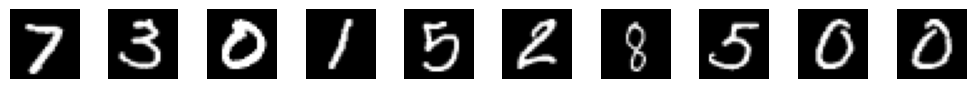

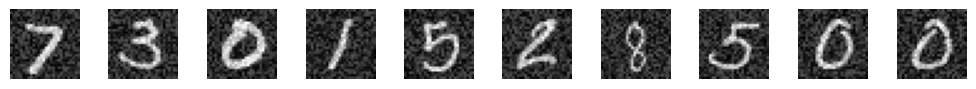

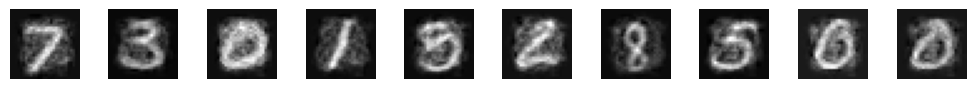

In [47]:
datasets = loadMNIST('datasets/SubsetMNIST')
clean_data = datasets['cleanMNIST']
data = datasets['noisyMNIST']
data = clean_data["test"] + np.random.rand(2000,28,28)*0.5

dim_pca = 80
lmbda = 5e-7
sigma_encoder = 8
sigma_decoder = 3
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit(clean_data['train'].astype("float32"))
pred = denoiser.denoise(data.astype("float32"))
pred = pred.reshape(data.shape)

plot_multiple_images(clean_data['test'])
plot_multiple_images(data)
plot_multiple_images(pred)

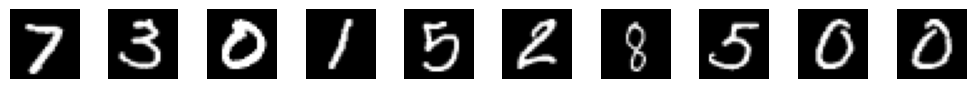

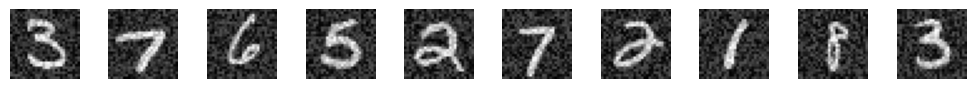

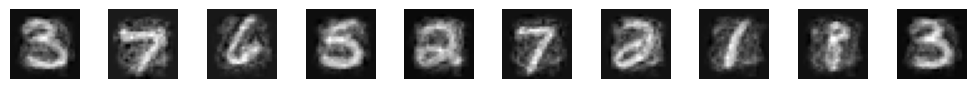

In [51]:
plot_multiple_images(clean_data['test'])
plot_multiple_images(np.roll(data, 1430, axis = 0))
plot_multiple_images(np.roll(pred, 1430, axis = 0))

In [13]:
data.shape

(2000, 28, 28)

Just a test class, where I tried to find the kernel's eigenvalue by using an optimizer.

class kernelPCA:
    
    def __init__(self,kernel, r=2):
        self.kernel = kernel          # <---
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corresp
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.support = None # Data points where the features are evaluated
        self.r =r ## Number of principal components
        self.Ku = None
    def compute_PCA(self, X):
        # assigns the vectors
        self.support = X
        kern = self.kernel(X,X)
        # Or a smarter way
        C=np.eye(kern.shape[0])-np.ones(kern.shape)/kern.shape[0] # centering
        self.Ku=C.dot(kern).dot(C)
        self.lmbda, self.alpha = np.linalg.eig(self.Ku)
        self.lmbda = self.lmbda[1: 1 + self.r].real
        self.alpha = self.alpha[:,1: 1 + self.r].real #already normalized to unity
        #Failure
        ###
        # #Constraints
        # def fun_eq(alpha):
        #     # alpha_1 = alpha.reshape(self.r,N)
        #     # alpha_2 = alpha.reshape(self.r,N).T
        #     return (alpha.reshape(self.r,N) @ alpha.reshape(self.r,N).T - np.eye(self.r)).flatten()

        # def jac_eq(alpha):
        #     Jac = np.zeros((self.r**2, N*self.r))
        #     for i in range(self.r):
        #         for j in range(self.r):
        #             if (i == j):
        #                 Jac[i*self.r + i][i*N : (i + 1)*N] = 2*alpha[self.r*i : i*self.r + N]
        #             else:
        #                 Jac[i*self.r + j][i*N : (i + 1)*N] = alpha[N : 2*N]
        #                 Jac[i*self.r + j][j*N : (j + 1)*N] = alpha[ : N]
        #     return Jac

        # #Objective function
        # def loss(alpha):
        #     K_diag = np.kron(np.eye(self.r,dtype=int),K)
        #     #print(1/2*alpha.T @ K_diag @ alpha)
        #     return 1/2*alpha.T @ K_diag @ alpha

        # constraints = ({'type' : 'eq', 'fun' : fun_eq, 'jac' : jac_eq})
        # optRes = optimize.minimize(fun = loss,
        #                     x0=1/2*np.ones(N*self.r),
        #                     method='SLSQP',
        #                     constraints=constraints)
        #self.alpha = optRes.x

    ###
    def transform(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N x r
        M = x.shape[0]
        N = self.support.shape[0]
        Z = np.empty((M, self.r))
        K = self.kernel(self.support,x)
        print(self.support.shape)
        for i in range(self.r):
            Z[:,i] = self.alpha.T[i] @ self.K - 1/N*np.sum(self.alpha.T[i])*np.sum(K,axis = 0)
        return Z